In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import open3d as o3d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d
import time
import moviepy.video.io.ImageSequenceClip
import copy
import networkx as nx
import math
sys.path.insert(0,'/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')

from Signal_processing_utils import dx_dt, get_activity_interval, bilateral_filter_smoothing
from Interpolation_Util import CubicSplineInterpolation, CatmullRomSplineInterpolation
from sklearn.linear_model import Ridge
from utils import *

In [3]:
%load_ext autoreload
%autoreload 1

%aimport Signal_processing_utils
%aimport Interpolation_Util
%aimport utils
# %matplotlib widget
%matplotlib inline

In [4]:
# input block
motion_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"
calibration_data_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/MySlate_17_iPhone_cal.csv"

# motion_data_path = "C:/Users/evan1/Documents/staggered_face/data/live_link_data/LiveLinkFace_20220926_MySlate_7_Evans_Iphone/MySlate_7_Evans_Iphone.csv"
mesh_to_name_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_mesh_number_to_AU_name.json"
name_to_mesh_path = "/Users/evanpan/Documents/GitHub/staggered_face/models/joonho_AU_name_to_mesh_number.json"
out_path = "/Volumes/EVAN_DISK/MASC/staggered_face/Pilot_Experimental_study/Iphone_AR_kit/evan_take_jul4/for_maya_json.json"
model_path = "/Users/evanpan/Documents/GitHub/staggered_face/data/Apple blendshapes51 OBJs/OBJs"
mode = "acceleration"

# Load input

In [5]:
times, values_dict = load_apple_motion(motion_data_path, 30, calibration_data_path)
all_AU = []
labels = list(values_dict.keys())
for i in range(0, len(labels)):
    all_AU.append(labels[i])
model = BasicBlendshapeModel()
model = load_blendshape_model(model_path, model)
animation = BlendshapeAnimation(model, calibration_data_path)
# play_animation(animation, save_video=True)
ARkit_2_blendshapeModel_map = {'eyeblink_r': 'eyeblinkright', 'eyelookdown_r': 'eyelookdownright', 'eyelookin_r': 'eyelookinright', 'eyelookout_r': 'eyelookoutright', 'eyelookup_r': 'eyelookupright', 'eyesquint_r': 'eyesquintright', 'eyewide_r': 'eyewideright', 'eyeblink_l': 'eyeblinkleft', 'eyelookdown_l': 'eyelookdownleft', 'eyelookin_l': 'eyelookinleft', 'eyelookout_l': 'eyelookoutleft', 'eyelookup_l': 'eyelookupleft', 'eyesquint_l': 'eyesquintleft', 'eyewide_l': 'eyewideleft', 'jawforward': 'jawforward', 'jawright': 'jawright', 'jawleft': 'jawleft', 'jawopen': 'jawopen', 'mouthclose': 'mouthclose', 'mouthfunnel': 'mouthfunnel', 'mouthpucker': 'mouthpucker', 'mouthright': 'mouthright', 'mouthleft': 'mouthleft', 'mouthsmile_r': 'mouthsmileright', 'mouthsmile_l': 'mouthsmileleft', 'mouthfrown_r': 'mouthfrownright', 'mouthfrown_l': 'mouthfrownleft', 'mouthdimple_r': 'mouthdimpleright', 'mouthdimple_l': 'mouthdimpleleft', 'mouthstretch_r': 'mouthstretchright', 'mouthstretch_l': 'mouthstretchleft', 'mouthrolllower': 'mouthrolllower', 'mouthrollupper': 'mouthrollupper', 'mouthshruglower': 'mouthshruglower', 'mouthshrugupper': 'mouthshrugupper', 'mouthpress_r': 'mouthpressright', 'mouthpress_l': 'mouthpressleft', 'mouthlowerdown_r': 'mouthlowerdownright', 'mouthlowerdown_l': 'mouthlowerdownleft', 'mouthupperup_r': 'mouthupperupright', 'mouthupperup_l': 'mouthupperupleft', 'browdown_r': 'browdownright', 'browdown_l': 'browdownleft', 'browinnerup': 'browinnerup', 'browouterup_r': 'browouterupright', 'browouterup_l': 'browouterupleft', 'cheekpuff': 'cheekpuff', 'cheeksquint_r': 'cheeksquintright', 'cheeksquint_l': 'cheeksquintleft', 'nosesneer_r': 'nosesneerright', 'nosesneer_l': 'nosesneerleft'}

## Get key_points

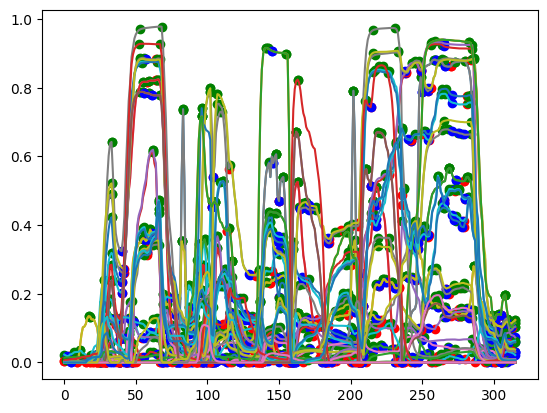

In [6]:
onset_threshold = 0.05
offset_threshold = 0.05
noise_threshold = 0.2
plt.clf()
curve_index = 0
onset_curve_dict = {}
offset_curve_dict = {}
labeled_key_frame_dict = {}
for i in range(curve_index, len(all_AU)):
    au_i = all_AU[i]
    au_i_curve = values_dict[au_i]
    filtered_au_i_curve = au_i_curve
    plt.plot(filtered_au_i_curve, label="original")
    # find onset
    au_i_vel_curve_forward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=1)
    au_i_vel_curve_backward = dx_dt(filtered_au_i_curve, dt=1/30.0, method=3)
    onsets = np.zeros(au_i_vel_curve_forward.shape)
    offsets = np.zeros(au_i_vel_curve_forward.shape)
    ts = list(range(0, au_i_vel_curve_forward.shape[0]))
    for t in ts:
        # if the AU is increasing sufficiently we set the element in the onsets array it to 1
        # here we use backward differences to capture the onset t[i+1] - t[i]
        if au_i_vel_curve_backward[t] >= onset_threshold or au_i_vel_curve_forward[t] >= onset_threshold: 
            onsets[t] = 1
        # if the AU is decreasing sufficiently we set the element in the offsets array it to 1
        # here we use backward difference 
        if au_i_vel_curve_forward[t] <= -offset_threshold or au_i_vel_curve_backward[t] <= -offset_threshold:
            offsets[t] = 1
    # merge nearby active labels into intervals. (i.e. if there is a group of 1s they are now clustered)
    action_unit_onset_activity = get_activity_interval(onsets, np.array(ts))
    action_unit_offset_activity = get_activity_interval(offsets, np.array(ts))
    onset_curve_dict[au_i] = onsets
    offset_curve_dict[au_i] = offsets
    # activation, peak, sustain and deactivation values
    activation = [x[0] for x in action_unit_onset_activity]
    peak = [x[1] for x in action_unit_onset_activity]
    sustain = [x[0] for x in action_unit_offset_activity]
    deactivation = [x[1] for x in action_unit_offset_activity]
    # plot all the key points
    labeled_key_frames = []
    plt.scatter(activation, filtered_au_i_curve[activation], c="r", label="motion onset")
    plt.scatter(peak, filtered_au_i_curve[peak], c="g", label="motion peak")
    plt.scatter(sustain, filtered_au_i_curve[sustain], c="g", label="motion sustain")
    plt.scatter(deactivation, filtered_au_i_curve[deactivation], c="b", label="motion end")
    for pts in activation:
        labeled_key_frames.append([pts, "a"])
    for pts in peak:
        labeled_key_frames.append([pts, "p"])
    for pts in sustain:
        labeled_key_frames.append([pts, "s"])
    for pts in deactivation:
        labeled_key_frames.append([pts, "d"])
    # sort all the potential key frames by time
    if len(labeled_key_frames) == 0:
        labeled_key_frames = [[0, "a"], [len(ts)-1, "d"]]
    labeled_key_frames = sorted(labeled_key_frames, key=lambda x: x[0])
    filtered_labeled_kay_frames = []
    ff = 0
    while ff < len(labeled_key_frames) - 1:
        current = labeled_key_frames[ff]
        next = labeled_key_frames[ff+1]
        if current[0] != next[0]:
            filtered_labeled_kay_frames.append(current)
        # elif (current[1] == "a" and next[1] == "p") or (current[1] == "s" and next[1] == "d"):
        elif (current[1] == "a" and next[1] == "d") or (current[1] == "d" and next[1] == "a"):
            filtered_labeled_kay_frames.append([current[0], "d"])
            filtered_labeled_kay_frames.append([current[0], "a"])
            ff += 1
        elif au_i_curve[current[0]] <= noise_threshold:
            filtered_labeled_kay_frames.append([current[0], "z"])
            filtered_labeled_kay_frames.append([current[0], "z"])
            ff += 1
        ff += 1
    # add the last frame (which is probably missing )
    filtered_labeled_kay_frames.append(labeled_key_frames[-1])
    # replace the keyframed with the filtered version
    labeled_key_frames = copy.deepcopy(filtered_labeled_kay_frames)
    # save the keyframe
    labeled_key_frame_dict[au_i] = labeled_key_frames
    plotting_key_frames = [x[0] for x in labeled_key_frames]
    approximation = CatmullRomSplineInterpolation(np.array(ts)[plotting_key_frames], filtered_au_i_curve[plotting_key_frames], tao=0.2)
    # plt.plot(np.maximum(0, approximation.eval(np.array(ts))), label="catmull rom")

## Aggregating keyframes through summation

In [7]:
kf_width = 3

In [8]:
times = np.array(times)
kf_times_dict = {}
kf_times_aggregate = np.zeros(times.shape)
for key in labeled_key_frame_dict:
    kf_indices = labeled_key_frame_dict[key]
    kf_indices = [x[0] for x in kf_indices]
    kf_times = np.zeros(times.shape)
    for t in range(0, len(kf_indices)):
        kf_times[kf_indices[t]] = 1
    kf_times = gaussian_filter1d(kf_times, kf_width) 
    kf_times_aggregate += kf_times
    kf_times_dict[key] = kf_times

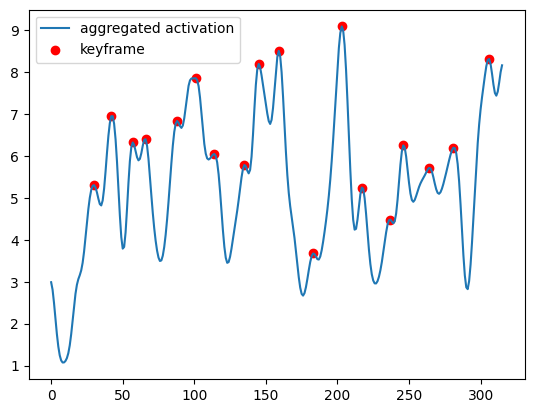

In [9]:
from scipy.signal import argrelextrema
thre = 3
# for local extremes on the aggregated curve
extremes = argrelextrema(kf_times_aggregate, np.greater)[0]
extremes_filtered = []
for i in range(0, len(extremes)):
    if kf_times_aggregate[extremes[i]] >= thre:
        extremes_filtered.append(extremes[i])
plt.clf()
plt.plot(kf_times_aggregate, label="aggregated activation")
plt.scatter(extremes_filtered, kf_times_aggregate[extremes_filtered], c="r", label="keyframe")
plt.legend()
plt.show()


In [10]:
superframes:list[SuperFrame] = []
for i in range(0, len(extremes_filtered)):
    # time of a global keyframe
    kf_time = extremes_filtered[i]
    # add all the keyframes within a certain distance from these key points
    groupings = []
    for key in kf_times_dict:
        for isolated_kf_time in labeled_key_frame_dict[key]:
            if abs(isolated_kf_time[0] - kf_time) <= kf_width:
                groupings.append([key, isolated_kf_time[0]])
    superframes.append(SuperFrame(groupings))

In [11]:
visualize_superpose(animation, superframes, values_dict, True, "/Users/evanpan/Desktop/super_pose_summation_w=3_no_pause.mp4", pause_length=0)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Moviepy - Building video /Users/evanpan/Desktop/super_pose_summation_w=3_no_pause.mp4.
Moviepy - Writing video /Users/evanpan/Desktop/super_pose_summation_w=3_no_pause.mp4



Moviepy - Done !
Moviepy - video ready /Users/evanpan/Desktop/super_pose_summation_w=3_no_pause.mp4


[array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 array([[[1., 1., 1.],
         [1., 1.,